# K-Nearest Neighbors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
selected_samples = iris.target > 0
X = iris.data[['petal length (cm)', 'petal width (cm)']][selected_samples]
y = iris.target[selected_samples] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create the Algorithm from Scratch

In [3]:
class KNeighborsClassifierFromScratch:
    PLOT_X_LIM = [3, 7]
    PLOT_Y_LIM = [0, 4]
    CMAP = ListedColormap(['tab:blue', 'tab:orange'])
    
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.X_train_len = None
        self.X_test_len = None
    
    def fit(self, x_train_param, y_train_param):
        self.X_train = x_train_param
        self.y_train = y_train_param
        
    def get_xs_transformed(self, x_test_param):
        x_train_transformed = np.vstack([X_train] * self.X_test_len)
        x_test_transformed = np.array(x_test_param).repeat(self.X_train_len, axis=0)
    
        return x_train_transformed, x_test_transformed
        
    def get_nearest_instance_indexes(self, x_train_transformed_param, x_test_transformed_param):
        differences = x_train_transformed_param - x_test_transformed_param
        distances = np.linalg.norm(differences, axis=1)
        split_distances = np.split(distances, self.X_test_len)

        return np.argpartition(split_distances, self.n_neighbors)[:, :self.n_neighbors]

    def get_predicted_classes(self, y_train_param, nearest_instance_indexes_param):
        nearest_instance_classes = np.array(y_train_param)[nearest_instance_indexes_param]
        reshaped_nearest_instance_classes = nearest_instance_classes.reshape((self.X_test_len, 
                                                                              self.n_neighbors))
        target_values_nr = np.max(y_train_param) + 1
        counted_classes = np.array([
            np.bincount(row, minlength=target_values_nr) 
            for row in reshaped_nearest_instance_classes
        ])
    
        return np.argmax(counted_classes, axis=1)
        
    def animate(self, frame, ax, x_test_param, nearest_instances, predicted_classes):
        prediction_nr = int(np.floor(frame / 2) + 1)
        cut_x_test = x_test_param[:prediction_nr * 2]
        cut_nearest_instances = nearest_instances[:prediction_nr * 2]
        cut_predicted_classes = predicted_classes[:prediction_nr * 2]

        ax.clear()
        ax.set_xlim(self.PLOT_X_LIM)
        ax.set_ylim(self.PLOT_Y_LIM)
        ax.axhline(0, color='black')
        ax.axvline(0, color='black')

        # Draw training data points
        scatter = ax.scatter(self.X_train.iloc[:, 0], self.X_train.iloc[:, 1], c=self.y_train, 
                             cmap=self.CMAP, edgecolors='black', alpha=0.5)

        ax.legend(handles=scatter.legend_elements()[0], labels=['Versicolor', 'Virginica'])

        # Draw testing data points
        ax.scatter(cut_x_test[:, 0][:-2], cut_x_test[:, 1][:-2], c=cut_predicted_classes[:-2], 
                   cmap=self.CMAP, edgecolors='black', marker='s')
        ax.scatter(cut_x_test[:, 0][-2:], cut_x_test[:, 1][-2:], c='red', edgecolors='black', 
                   marker='s')

        # Draw lines between training and testing data points
        x_test_instance = cut_x_test[(prediction_nr * 2) - 1]

        if frame % 2 != 0:
            for nearest_instance in cut_nearest_instances[(prediction_nr * 2) - 1]:
                line_coordinates_x = [x_test_instance[0], nearest_instance[0]]
                line_coordinates_y = [x_test_instance[1], nearest_instance[1]]
    
                ax.plot(line_coordinates_x, line_coordinates_y, color='red')

        ax.set_axisbelow(True)
        ax.grid(color='grey')
        ax.set_title(f"#{prediction_nr} Prediction")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_xticks(np.arange(self.PLOT_X_LIM[0], self.PLOT_X_LIM[1] + 1))
        ax.set_yticks(np.arange(self.PLOT_Y_LIM[0], self.PLOT_Y_LIM[1] + 1))
        
    def predict(self, x_test_param, create_animation=False):
        self.X_train_len = len(X_train)
        self.X_test_len = len(X_test)        

        x_train_transformed, x_test_transformed = self.get_xs_transformed(x_test_param)
        nearest_instance_indexes = self.get_nearest_instance_indexes(x_train_transformed, 
                                                                     x_test_transformed)
        predicted_classes = self.get_predicted_classes(y_train, nearest_instance_indexes)
        
        if create_animation:
            if len(x_test_param.iloc[0]) != 2:
                raise Exception(("This K-Nearest Neighbors animation implementation works only "
                                 "with two-dimensional features!"))
            
            frames = self.X_test_len * 2
            nearest_instances = np.array(X_train)[nearest_instance_indexes]

            fig, ax = plt.subplots(figsize=plt.figaspect(1.))
            animation = FuncAnimation(fig, self.animate, frames, fargs=(
                ax, np.array(x_test_param).repeat(2, axis=0), nearest_instances.repeat(2, axis=0), 
                predicted_classes.repeat(2, axis=0)
            ))

            animation.save('k_nearest_neighbors.gif', writer=PillowWriter(fps=10), dpi=200)
        
        return predicted_classes

## Create an Animation and Compare Implementations

0.8

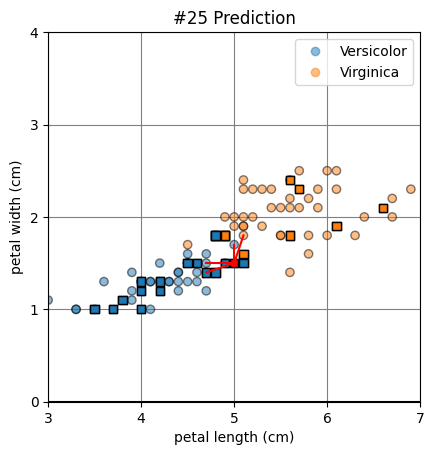

In [4]:
model_from_scratch = KNeighborsClassifierFromScratch()

model_from_scratch.fit(X_train, y_train)

y_pred = model_from_scratch.predict(X_test, create_animation=True)

accuracy_score(y_test, y_pred)

In [5]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.8